# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Для определение возраста покупателя будут предлагаться товара определенной возростной группы.

## Исследовательский анализ данных

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image

In [3]:

data = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [4]:
data.head() # посмотрим на данные датасета

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Размер выборки выведен. Выборка относительно небольшая, но мы еще можем нарастить ее, применяя аугментации


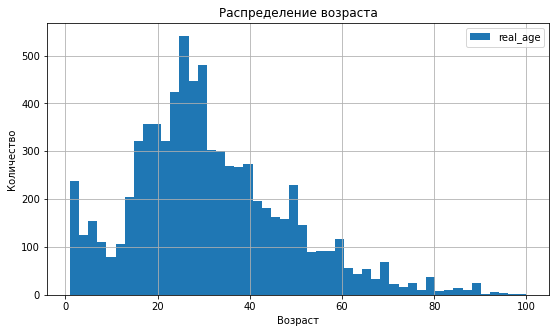

In [6]:
data.plot(kind='hist',figsize=(9,5),bins=100, grid=True)
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество');


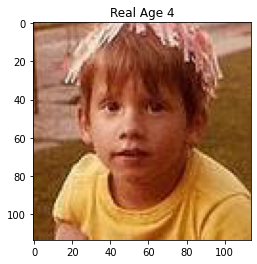

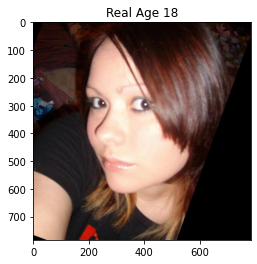

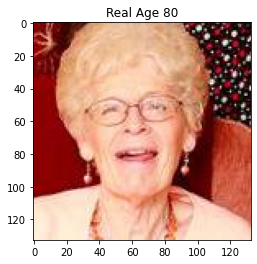

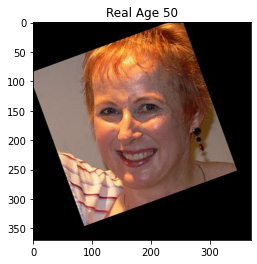

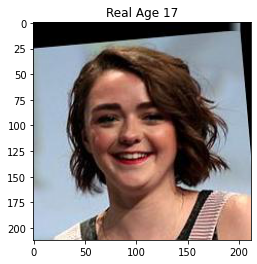

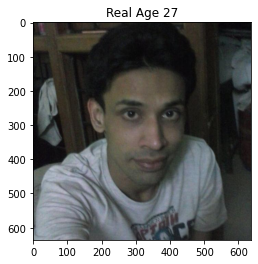

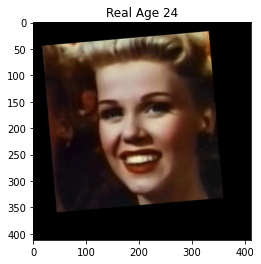

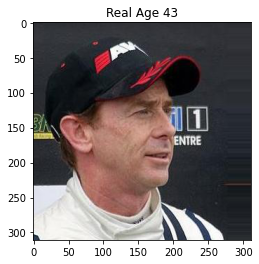

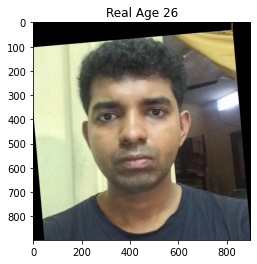

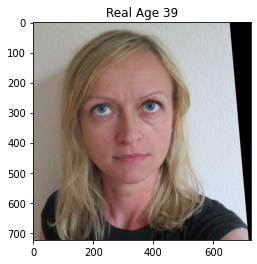

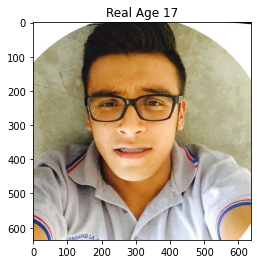

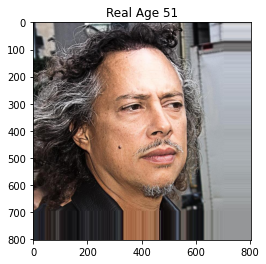

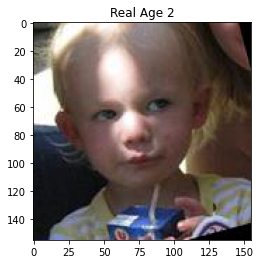

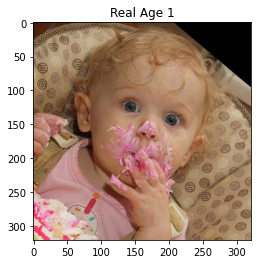

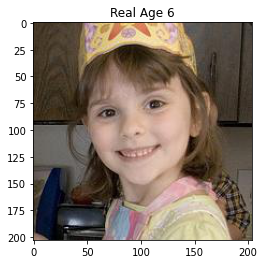

In [11]:
for i,k in zip(data.file_name[:15],data.real_age[:15]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.show()

заметим, что датасете 7591 фотографий, некоторые из них сняты под углом или с посторонними предметами. В нашем датасете мы имеем преобладающее большинство размеченных фотографий с возрастом от 20 до 40 лет с пиковым значением в 30 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd



def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow

def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```



```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-09-05 17:14:24.336149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-05 17:14:24.623151: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 56s - loss: 226.9483 - mae: 10.7799 - val_loss: 702.5239 - val_mae: 21.5659
Epoch 2/15
178/178 - 48s - loss: 75.7843 - mae: 6.5442 - val_loss: 762.5826 - val_mae: 22.6175
Epoch 3/15
178/178 - 49s - loss: 50.4913 - mae: 5.4195 - val_loss: 281.8435 - val_mae: 13.6428
Epoch 4/15
178/178 - 48s - loss: 35.4936 - mae: 4.5502 - val_loss: 129.8139 - val_mae: 8.8109
Epoch 5/15
178/178 - 49s - loss: 26.5011 - mae: 3.9012 - val_loss: 75.7481 - val_mae: 6.5262
Epoch 6/15
178/178 - 49s - loss: 21.8052 - mae: 3.5570 - val_loss: 78.8795 - val_mae: 6.7139
Epoch 7/15
178/178 - 49s - loss: 17.3033 - mae: 3.1871 - val_loss: 70.7755 - val_mae: 6.4798
Epoch 8/15
178/178 - 49s - loss: 14.4517 - mae: 2.9388 - val_loss: 70.1454 - val_mae: 6.2693
Epoch 9/15
178/178 - 50s - loss: 11.7976 - mae: 2.6265 - val_loss: 63.1656 - val_mae: 5.8302
Epoch 10/15
178/178 - 52s - loss: 11.1392 - mae: 2.5485 - val_loss: 71.3036 - val_mae: 6.2766
Epoch 11/15
178/178 - 52s - loss: 10.6904 - mae: 2.4835 - val_loss: 70.1014 - val_mae: 6.5794
Epoch 12/15
178/178 - 49s - loss: 8.5664 - mae: 2.2192 - val_loss: 67.9779 - val_mae: 6.3094
Epoch 13/15
178/178 - 48s - loss: 8.4531 - mae: 2.1922 - val_loss: 64.1698 - val_mae: 6.1651
Epoch 14/15
178/178 - 48s - loss: 7.7661 - mae: 2.0807 - val_loss: 58.8635 - val_mae: 5.6834
Epoch 15/15
178/178 - 49s - loss: 7.6131 - mae: 2.0855 - val_loss: 62.4819 - val_mae: 6.0101
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 62.4819 - mae: 6.0101
Test MAE: 6.0101

```

## Анализ обученной модели

датасет состоял из 7591 фотографий размером 224х224. Многие фото повернуты, поэтому мы должны добавить изображения с увеличенным вращением в тренировочную выборку.также есть фото с цветовыми искажениями, что составляет трудность в обучении. Посмотрев на гистограмму, заметим скос вправо, медианное значение 29 лет, среднее - 31,2. 

В качестве основы за модель взяли уже предобученную нейросеть с архитектурой ResNet50 и дополнительно обучили её на наших данных без замораживания. В выходном слое,для более точного обучения модели, использовали оптимизацию Adam c шагом обучения 0,0001 а в качестве функции потерь использовалась mse, что немного ускорило процесс обучения.

С такими параметрами мы протестировали нашу модель на 15 эпохах, и уже на 2 эпохе обучения на тестовых данных она достигла значения по метрике равное 6.5442, что  меньше 7 и с каждой эпохой значение mse снижалость 